In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
import numpy as np
from datetime import datetime

In [2]:
from tools import savefig, initialize_datetime

In [3]:
data = pd.read_json("data/flink/pr-flat_20220602-13h35m41s_apache_flink_master_prs-brief.txt", lines=True)

In [4]:
n = data.shape[0]
max_pr = data['number'].max()

In [5]:
initialize_datetime(data)

In [6]:
data = data.set_index('createdAt')
data['createdAt'] = data.index

In [7]:
data['_count'] = 1
data['totalCount'] = data['_count'].cumsum()

## Time to first review vs Life time

In [8]:
def min_review(row):
    ts = np.nan
    ts2 = np.nan
    if isinstance(row['firstReviewThreadCreatedAt'], pd.Timestamp): 
        ts = row['firstReviewThreadCreatedAt']
    if isinstance(row['firstReviewCreatedAt'], pd.Timestamp):
        ts2 = row['firstReviewCreatedAt']
    if ts is np.nan:
        return ts2
    if ts2 is np.nan:
        return ts
    return min(ts, ts2)

def first_review_column(dataset: pd.DataFrame):
    assert 'firstReviewCreatedAt' in dataset.columns
    assert 'firstReviewThreadCreatedAt' in dataset.columns
    return dataset.apply(min_review, axis=1)

data['firstReview'] = first_review_column(data)

In [9]:
def time_to_review(row):
    if row['createdAt'] is np.nan or row['createdAt'] is None:
        return np.nan
    if row['firstReview'] is np.nan or row['firstReview'] is None:
        return np.nan
    return pd.to_datetime(row['firstReview']) - pd.to_datetime(row['createdAt'])

def time_to_review_column(dataset: pd.DataFrame):
    assert 'createdAt' in dataset.columns
    assert 'firstReview' in dataset.columns
    return dataset.apply(time_to_review, axis=1)

data['timeToReview'] = time_to_review_column(data)

In [10]:
def life_time(row):
    if row['createdAt'] is np.nan or row['createdAt'] is None:
        return np.nan
    if row['closedAt'] is np.nan or row['closedAt'] is None:
        return np.nan
    return pd.to_datetime(row['closedAt']) - pd.to_datetime(row['createdAt'])

def life_time_column(dataset: pd.DataFrame):
    assert 'createdAt' in dataset.columns
    assert 'closedAt' in dataset.columns
    return dataset.apply(life_time, axis=1)

data['lifetime'] = life_time_column(data)

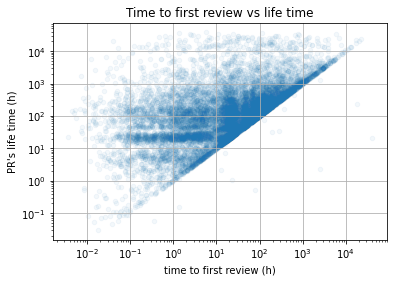

In [11]:
lifetime_and_ttfr = data.loc[~data['lifetime'].isna() & ~data['timeToReview'].isna()].copy()

def plot_time_to_first_review_vs_lifetime(dataset: pd.DataFrame):
    f, ax = plt.subplots()
    dataset = dataset.copy()
    dataset['lifetimeInHours'] = dataset['lifetime'].dt.total_seconds()/ (60*60)
    dataset['timeToReviewInHours'] = dataset['timeToReview'].dt.total_seconds()/ (60*60)
    dataset.plot.scatter(x='timeToReviewInHours', y='lifetimeInHours', alpha=0.05, ax=ax)
    ax.set(xlabel='time to first review (h)', ylabel='PR\'s life time (h)')
    ax.grid()
    ax.loglog()
    plt.title('Time to first review vs life time')
    
plot_time_to_first_review_vs_lifetime(lifetime_and_ttfr)